In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install import-ipynb
%cd /content/drive/My\ Drive/Colab\ Notebooks/RetinaSmartCamera/notebooks

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=7740a675de9699a9a05f3919a011cd423046915551229b37003fb0a37e7ce629
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/notebooks


In [3]:
import import_ipynb
import RetinaUtils as ru

import DataLoaders

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data.dataset import Dataset, Subset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

import re
import os

importing Jupyter notebook from RetinaUtils.ipynb
importing Jupyter notebook from DataLoaders.ipynb


In [4]:
def pad(x, amount):
    padding = np.zeros((amount))
    vec = np.zeros((125930,3))
    for i in range(3):
        vec[:,i]=np.hstack((padding,x[:,i],padding))
    return vec
    #return np.hstack((padding, x, padding))

def img_to_vector(img, R, padding):
    batches = 8
    img = img.view(8,1920,1080,3)
    #img = img.cpu().numpy()

    x = img.shape[2]/2
    y = img.shape[1]/2
    fixation = (y,x)

    vector_batches = torch.empty(batches, 3,50000,1)
    
    for i in range(0, batches):
        
        V = R.sample(img[i].cpu(), fixation)
        
        #V = pad(V, padding)
        
        V = np.reshape(V, (3, len(V), 1))
        V = torch.from_numpy(V)
        
        vector_batches[i,:,:] = V

    #print(vector_batches.shape)
    #vector_batches.to(device)
    return vector_batches

In [5]:
#Test
R = ru.Retina()

impath = "/content/drive/My Drive/Colab Notebooks/RetinaVision/botw.jpg"
img = np.float64(cv2.imread(impath))
x = img.shape[2]/2
y = img.shape[1]/2
fixation = (y,x)

data_dir = '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/retina_data/'
R.loadLoc(data_dir+'ret50k_loc.pkl')
R.loadCoeff(data_dir+'ret50k_coeff.pkl')
R.prepare(img.shape, fixation)

V = R.sample(img, fixation)

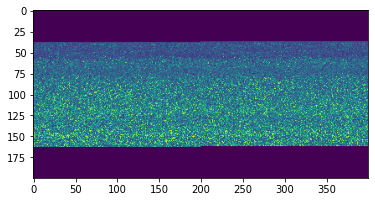

In [ ]:
#Autoencoder model from ConvAutoencoder has the following shape:
#Encoder:
#(8, 3, 257, 490) -> (8, 6, 253, 486) -> (8, 6, 126, 243) -> (8, 12, 122, 239) -> (8, 12, 61, 119) -> (8, 16, 57, 115)
#Decoder:
#(8, 16, 57, 115) -> (8, 12, 61, 119) -> (8, 12, 122, 239) -> (8, 6, 126, 243) -> (8, 6, 253, 486) -> (8, 3, 257, 490)

#Need to get (50000, 1) image vector to (16, 57, 115)
#(8, 1, 50000) -> 
plt.imshow(np.reshape(pad(V, 15000), (200, 400)))

In [6]:
class RetinaEncoder(nn.Module):
    def __init__(self):
        super(RetinaEncoder, self).__init__()
        #self.R = R
        #self.img_to_vector = img_to_vector

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.conv3 = nn.Conv2d(12, 16, kernel_size=5)

        #self.l1 = nn.Linear(45, 57)
        #self.l2 = nn.Linear(57, 115)

        """
        self.encode = nn.Sequential(nn.Conv1d(1, 3, kernel_size=5),
                                    nn.MaxPool1d(kernel_size=2),
                                    nn.Conv1d(3, 6, kernel_size=5),
                                    nn.MaxPool1d(kernel_size=2),
                                    nn.Conv1d(6, 12, kernel_size=5),
                                    nn.Conv1d(12, 16, kernel_size=5),
                                    nn.Linear(12489, 6555)
                                    )
        """
        #self.conv2 = nn.Conv2d(3, 6, kernel_size=1)
    
    def forward(self, x):
        #x = self.img_to_vector(x, self.R, 0)
        x = x.view(8, 3, 257, 490)
        
    
        x = self.conv1(x)
        x, ind_1 = self.maxpool1(x)
        x = self.conv2(x)
        x, ind_2 = self.maxpool2(x)
        x = self.conv3(x)
        
        #x = x.view(8,490,257,3)
        """
        print(x.shape)
        x = x.view(8, 16, 57, 45)
        x = self.l1(x)

        print(x.shape)
        x = x.view(8, 16, 57, 57)
        x = self.l2(x)
        """
        return x, ind_1, ind_2

In [ ]:
m = RetinaEncoder(R)
V = m(img)
V[0].shape

(50000, 3)
torch.Size([1, 16, 45, 57])


torch.Size([1, 16, 57, 115])

In [7]:
path = torch.load('/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/best_cortical_ae_100_epochs_epoch_52.pt')

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), return_indices=True)
        self.unconv1 = nn.ConvTranspose2d(6,3,kernel_size=(5,5))
        self.maxunpool1 = nn.MaxUnpool2d(kernel_size=(2,2))
        self.unmaxunpool2 = nn.MaxUnpool2d(kernel_size=(2,2))
        
        self.encoder1 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(6, 12,kernel_size=(5,5)),
        )
        
        self.encoder2 = nn.Sequential(
            nn.Tanh(),
            nn.Conv2d(12, 16, kernel_size=(5,5)),
            nn.Tanh()
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 12, kernel_size=(5,5)),
            nn.Tanh()
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(12,6,kernel_size=(5,5)),
            nn.Tanh(),
        )
    def forward(self, x, ind_1, ind_2):
        # Decoder
        x = self.decoder2(x)
        
        #Maxunpool is not perfectly reversible, so to prevent ambiguity we must state what size our output is
        x = self.unmaxunpool2(x, ind_2, output_size=torch.Size([8, 12, 122, 239]))
        x = self.decoder1(x)
        
        x = self.maxunpool1(x,ind_1, output_size=torch.Size([8, 6, 253, 486]))
        x = self.unconv1(x)
        x = nn.Tanh()(x)
        return x


In [9]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(x):
        return x

In [10]:
convModel = Autoencoder()
convModel.load_state_dict(path['model_state_dict'])

<All keys matched successfully>

In [11]:
#modules = list(convModel.modules())[:]
#print(len(modules))
#print(modules)
convModel.conv1 = Identity()
convModel.maxpool1 = Identity()
convModel.encoder1 = Identity()
convModel.maxpool2 = Identity()
convModel.encoder2 = Identity()

for param in convModel.parameters():
    param.requires_grad = False

In [12]:
class MixedModel(nn.Module):
    def __init__(self, retinaEncoder, corticalDecoder):
        super(MixedModel, self).__init__()
        self.retinaEncoder = retinaEncoder
        self.corticalDecoder = corticalDecoder
    
    def forward(self, x):
        x, ind_1, ind_2 = self.retinaEncoder(x)
        x = self.corticalDecoder(x, ind_1, ind_2)
        return x

In [14]:
from DataLoaders import get_dataloader
dataloader = get_dataloader(image_type='original', skip=6, batch_size=8, shuffle=False)

cuda:0
Iterating over bag
Number of images for class  bag :  349
Iterating over beer
Number of images for class  beer :  362
Iterating over book
Number of images for class  book :  353
Iterating over case
Number of images for class  case :  327
Iterating over coffee
Number of images for class  coffee :  347
Iterating over cup
Number of images for class  cup :  373
Iterating over deodorant
Number of images for class  deodorant :  323
Iterating over eraser
Number of images for class  eraser :  353
Iterating over hole
Number of images for class  hole :  354
Iterating over mouse
Number of images for class  mouse :  335
Iterating over mug
Number of images for class  mug :  349
Iterating over sleep
Number of images for class  sleep :  348
Iterating over speaker
Number of images for class  speaker :  341
Iterating over spray
Number of images for class  spray :  339
Iterating over stapler
Number of images for class  stapler :  347
Iterating over tape
Number of images for class  tape :  332
Ite

In [16]:
cortical_images = get_dataloader(image_type='original_corticalimages',skip=6, batch_size=8, shuffle=False)

cuda:0
Iterating over bag
Number of images for class  bag :  349
Iterating over beer
Number of images for class  beer :  362
Iterating over book
Number of images for class  book :  353
Iterating over case
Number of images for class  case :  327
Iterating over coffee
Number of images for class  coffee :  347
Iterating over cup
Number of images for class  cup :  373
Iterating over deodorant
Number of images for class  deodorant :  323
Iterating over eraser
Number of images for class  eraser :  353
Iterating over hole
Number of images for class  hole :  354
Iterating over mouse
Number of images for class  mouse :  335
Iterating over mug
Number of images for class  mug :  349
Iterating over sleep
Number of images for class  sleep :  348
Iterating over speaker
Number of images for class  speaker :  341
Iterating over spray
Number of images for class  spray :  339
Iterating over stapler
Number of images for class  stapler :  347
Iterating over tape
Number of images for class  tape :  332
Ite

In [33]:
in_images = iter(dataloader['train'])
in_images = next(in_images)

out_images = iter(cortical_images['train'])
out_images = next(out_images)

In [36]:
len(dataloader['train'])
in_images[1].shape

torch.Size([8])

In [30]:
R = ru.Retina()

x = 1920/2
y = 1080/2
fixation = (y,x)

R.loadLoc(data_dir+'ret50k_loc.pkl')
R.loadCoeff(data_dir+'ret50k_coeff.pkl')
R.prepare((1920,1080,3), fixation)

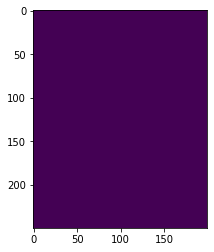

In [ ]:
test_image = images[0]
im = test_image[0]
im = im.view(1920,1080,3)
V_test =R.sample(im,(1080, 1920))
plt.imshow(np.reshape(V_test[:,2], (250, 200)))

In [31]:
#from ConvAutoencoder import run_model, plot_fig, imshow

retinaEncoder = RetinaEncoder()
mixedModel = MixedModel(retinaEncoder, convModel)

In [55]:
def load_img_vectors(dataloader):
    vectors = []
    j=0
    for data in iter(dataloader['train']):
        if j%100==0:
            print("Iteration {}".format(j))
        j += 1
        images, _ = data
        images.to(device) 
        images = images.view(8, 1920,1080,3)
        fixation = (1080/2,1920/2)

        vector_batches = torch.empty(8, 3,125930,1)
        for i in range(0, 8):
            V = R.sample(images[i], fixation)
            V = pad(V, 37965)
            V = np.reshape(V, (3, len(V), 1))
            V = torch.from_numpy(V)
            vector_batches[i,:,:] = V

        vectors.append(vector_batches)

In [56]:
g = load_img_vectors(dataloader)

Iteration 0


KeyboardInterrupt: ignored

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
final_model = run_model(mixedModel, dataloader, model_name='mixed_model', epochs=5, log_dir='log')

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


KeyboardInterrupt: ignored

In [49]:
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))

def plot_fig(input_img, output, epoch, iteration):
    fig = plt.figure(figsize=(24,4))
    input_img = input_img.cpu().numpy(),

    #Size of Cortical Image
    output_img = output.view(8, 3, 257, 490)
    output_img = output_img.cpu().detach().numpy()

    print(input_img[0][0].shape, output_img[0].shape)
    ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    imshow(input_img[0][0])
    plt.title('Input image at epoch: {}, iteration: {}'.format(epoch, iteration))
    ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    imshow(output_img[0])
    plt.title('Output image at epoch: {}, iteration: {}'.format(epoch, iteration))

    return fig

def run_model(model, dataloader, model_name, epochs=5, log_dir='log'):
    criterion = nn.MSELoss()

    # specify loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    model.to(device)

    writer = SummaryWriter(log_dir=log_dir)

    avg_train_loss = []
    avg_val_loss = []
    
    best = 1000000

    for epoch in range(1, epochs+1):
        i = 0
        #Train model
        model.train()
        train_loss=0

        out_images = iter(cortical_images['train'])
        for data in dataloader:
            true_cortical = next(out_images)
            true_cortical = true_cortical[0].to(device)
            images = data
            images = images.to(device)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            outputs = model(vector_batches)
            
            #print(outputs.shape)
            loss = criterion(outputs, true_cortical)
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)
            
            
            if i%99 == 0:
                print("Epoch: {}, Iteration: {}".format(epoch, i))
                writer.add_scalars(main_tag='Training loss', global_step=epoch * len(dataloader['train']) + i, 
                                   tag_scalar_dict={'Training loss' : train_loss})

                writer.add_figure('Input vs output', plot_fig(images, 
                                                              outputs,
                                                              epoch, i+1),
                                  global_step=epoch * len(dataloader['train']) + i)

            i += 1
        
        avg = train_loss/len(dataloader['train'])
        if avg < best:
            best = avg
            torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/best_'+model_name+'.pt')
        
        avg_train_loss.append(avg)

        print('----- Epoch ', epoch, '-----')
        print('Train accuracy: ', avg_train_loss[epoch-1])
        #print('Validation accuracy: ', avg_val_loss[epoch-1])
  
    for i in range(1, len(avg_train_loss) + 1):
        writer.add_scalars(main_tag='Accuracy/Loss', global_step=i, tag_scalar_dict={
            'Training loss' : avg_train_loss[i-1],
            })
    
    writer.close()

    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/content/drive/My Drive/Colab Notebooks/RetinaSmartCamera/models/final_'+model_name+'.pt')

    return model

In [45]:
writer.close()

NameError: ignored